# Assignment 1: MLPs and Backpropagation
### <font color='blue'> Due on November 9th, 2025 (23:59:59) </font>

Welcome to Comp541: Deep Learning Course!

Before you start, make sure you read the README.txt in the same directory as this notebook for important setup information. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning.

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [3]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/ozanozak/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://towardsdatascience.com/word-vectors-intuition-and-co-occurence-matrixes-a7f67cae16cd/)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](./imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*.

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [4]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [5]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [6]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1

    # ------------------
    # Write your implementation here.
    all_words = [word for sentence in corpus for word in sentence]
    corpus_set = set(all_words)
    corpus_words = sorted(list(corpus_set))
    num_corpus_words = len(corpus_words)
    
    # ------------------

    return corpus_words, num_corpus_words

In [7]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors.


In [8]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}

    # ------------------
    # Write your implementation here.
    M = np.zeros((num_words, num_words))
    word2ind = {word: index for index, word in enumerate(words)}
    for sentence in corpus:
        for center_index in range(len(sentence)):
            center_word = sentence[center_index]
            center_word_index = word2ind[center_word]
            
            window_start = max(0, center_index - window_size)
            window_end = min(center_index + window_size + 1, len(sentence))

            for word_index in range(window_start, window_end):
                if word_index != center_index:
                    M[center_word_index, word2ind[sentence[word_index]]] += 1
                    

    # ------------------

    return M, word2ind

In [9]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [10]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    # Write your implementation here.
    
    M_reduced = TruncatedSVD(n_components=k, n_iter=n_iters).fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

In [11]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [12]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for word in words:
        index = word2ind[word]
        x = M_reduced[index, 0]
        y = M_reduced[index, 1]
        plt.scatter(x, y, marker = 'x', color = 'red')
        plt.text(x, y, word, fontsize=9)
    plt.show()
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


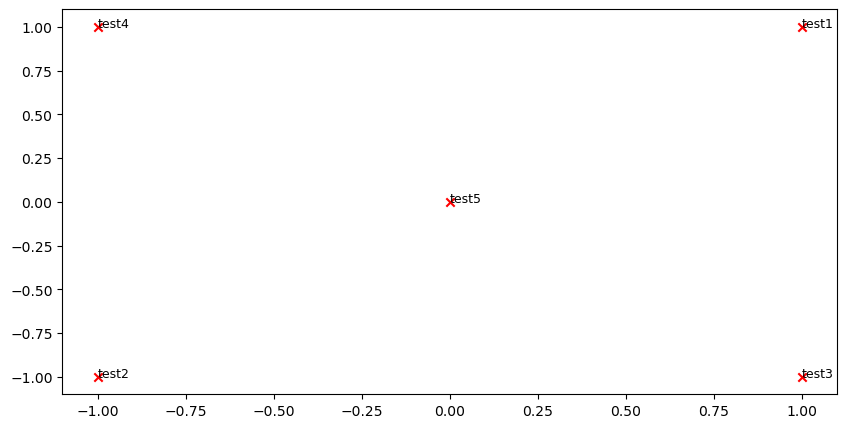

--------------------------------------------------------------------------------


In [13]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


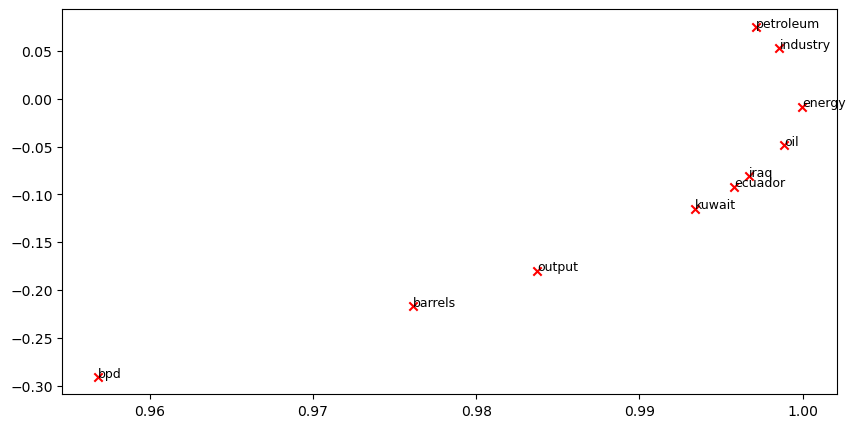

In [14]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>
Petroleum, industry, energy, oil, iraq, ecuador, kuwait cluster together. -> cluster 1

barrels, output cluster together. -> cluster 2

bpd -> cluster3

I think bpd should cluster together with barrels since bpd is sementically related to barrels. The reason might be since bpd is a technical abbreviation that might be used in different context such as rates or flows and barrels might be used in a context which is quantity or storage

## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [15]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [16]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [17]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [18]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

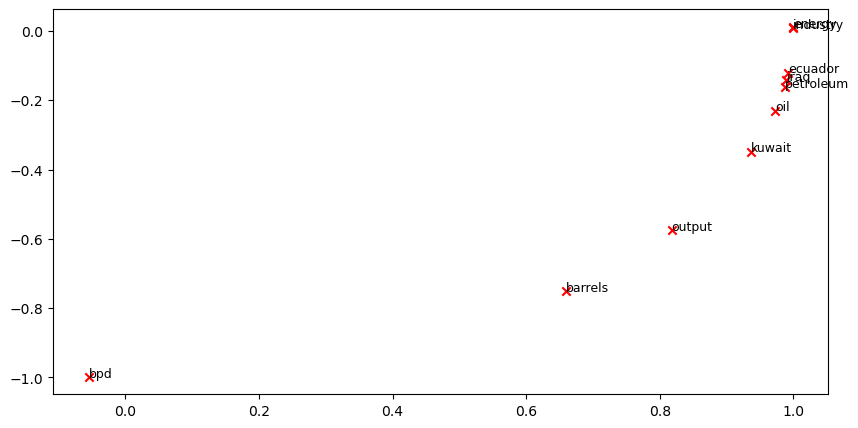

In [19]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

#### <font color="red">Write your answer here.</font>

1. **What clusters together in 2-dimensional embedding space?**
    1) Cluster 1: `bpd`
    2) Cluster 2: `barrels`, `output`, `kuwait` 
    3) Cluster 3:  `oil`, `petroleum`, `ecuador`, `iraq`
    4) Cluster 4: `industry`, `energy`

2. **What doesn’t cluster together that you think should have?**
    I think `oil` and `petroleum` shoul be in the same cluster since petrol is made out of oil. This might be because `oil` is more of a daily term while `petroleum` is a more technical term.

3. **How is the plot different from the one generated earlier from the co-occurrence matrix?**
    Co-occurence matrix grouped the words that appear near to each other but GloVe captures sementic relationships between words.

4. **What might cause this difference?**
    Difference might be caused by the different embedding method: Co-occurence matrix relies only on the word frequency within a window, whereas GloVe uses both co-occurence and context.


### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written]
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [20]:
# ------------------
# Write your implementation here.
words = ["leaves", "wave", "spring", "date", "court"]

for word in words:
    print(f"Top 10 similar words to '{word}':")
    similar_words = wv_from_bin.most_similar(word)
    for similar_word, similarity_rate in similar_words:
        print(f"{similar_word}: {similarity_rate}")
# ------------------

Top 10 similar words to 'leaves':
ends: 0.6128067970275879
leaf: 0.6027014851570129
stems: 0.5998532772064209
takes: 0.5902855396270752
leaving: 0.5761634707450867
grows: 0.5663397312164307
flowers: 0.5600921511650085
turns: 0.5536050796508789
leave: 0.5496848821640015
goes: 0.5434924960136414
Top 10 similar words to 'wave':
waves: 0.7608528137207031
triggered: 0.587844967842102
surge: 0.5674678087234497
massive: 0.5525227785110474
shock: 0.5491428971290588
tidal: 0.5435101985931396
sparked: 0.5430723428726196
swept: 0.5386255979537964
unleashed: 0.5371293425559998
tide: 0.5265918970108032
Top 10 similar words to 'spring':
summer: 0.8025314211845398
autumn: 0.7510948777198792
winter: 0.7315691709518433
fall: 0.6582662463188171
beginning: 0.6507853865623474
starting: 0.6281814575195312
year: 0.6142007112503052
start: 0.5800090432167053
next: 0.5771185159683228
during: 0.5726782083511353
Top 10 similar words to 'date':
dates: 0.8177138566970825
earliest: 0.6643297672271729
next: 0.655712

#### <font color="red">Write your answer here.</font>
I checked the words, **"leaves"**, **"wave"** and **"spring"**. For these words we can see different meanings:

1. **Wave**: shows water meanings such as **waves, tidal, tide** and action meanings such as **triggered, unleashed**.

2. **Leaves**: shows both plant meanings such as **grows, flowers** and action meanings such as **goes, turns**.

3. **Spring**: shows both season meanings such as **summer, autumn, winter** and time meanings such as **start, next, during**.

4. **Date**: shows only time/calendar meanings such as **early, beginning** and no sign of romantic meaning

5. **Court**: shows only legal meaning such as **case, appeal, verdict** and no sign of sport meaning

**Why most polysemous words don't work**

This is because of the training corpus. One meaning of a word dominates the training corpus and it overwhelms the rarer meanings.

### Question 2.3: Synonyms & Antonyms (2 points) [code + written]

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$.

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [21]:
# ------------------
# Write your implementation here.
word = "hard"
synonym = "challenging"
antonym = "easy"

dist1 = wv_from_bin.distance(word, synonym)
dist2 = wv_from_bin.distance(word, antonym)

print(f"Word 1 (w1): {word}")
print(f"Word 2 (w2) - synonym: {synonym}")
print(f"Word 3 (w3) - antonym: {antonym}")
print(f"\nCosine Distance between word and synonym (w1, w2): {dist1:.4f}")
print(f"Cosine Distance between word and antonym (w1, w3): {dist2:.4f}")
print(f"\nIs antonym closer? {dist2 < dist1}")
# ------------------

Word 1 (w1): hard
Word 2 (w2) - synonym: challenging
Word 3 (w3) - antonym: easy

Cosine Distance between word and synonym (w1, w2): 0.5313
Cosine Distance between word and antonym (w1, w3): 0.3334

Is antonym closer? True


#### <font color="red">Write your answer here.</font>

This might happen because most of the time a word and its antonym is used together in a sentence. Thus, their distance are becoming shorter.

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [22]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


Let $m$, $k$, $w$, and $x$ denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using **only** vectors $m$, $k$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?

#### <font color="red">Write your answer here.</font>
**Maximizing cosine similarity with x**: x = k - m + w

In the cordinate plane man and woman would be in the opposite sides in the axis (gender) and king and the answer queen would be placed above them along the royalty axis


### Question 2.5: Finding Analogies [code + written]  (1.5 points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [23]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['mother', 'brother'], negative=['sister']))

# ------------------

[('father', 0.8666962385177612),
 ('son', 0.8266637325286865),
 ('husband', 0.7366962432861328),
 ('grandfather', 0.7339598536491394),
 ('uncle', 0.7324445843696594),
 ('nephew', 0.7038999199867249),
 ('grandson', 0.6990761160850525),
 ('cousin', 0.6773477792739868),
 ('his', 0.6577787399291992),
 ('daughter', 0.6559266448020935)]


#### <font color="red">Write your answer here.</font>

**father:mother::brother:sister**

Word vectors capture gender relationship within family members. `Father-mother` are male-female partners and `brother-sister` male-female siblings. 

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [24]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['tall', 'cold'], negative=['hot']))

# ------------------

[('lanky', 0.48110902309417725),
 ('taller', 0.47406479716300964),
 ('height', 0.4668487310409546),
 ('5-foot', 0.45749321579933167),
 ('feet', 0.4515882134437561),
 ('6-foot', 0.4452100098133087),
 ('centimeters', 0.443575918674469),
 ('erect', 0.4427444338798523),
 ('rangy', 0.4390925168991089),
 ('stands', 0.43798333406448364)]


#### <font color="red">Write your answer here.</font>

**hot:cold::tall:short**

Temparature antonym `hot-cold` doesn't perfectly map to the height antonym tall-short. So, model gives `"lanky"` instad of short.

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [25]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.606891930103302),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321308970451355),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.611325740814209),
 ('employee', 0.5983108282089233),
 ('working', 0.5615329146385193),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278827548027039),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.5054521560668945),
 ('factory', 0.4940453767776489)]


#### <font color="red">Write your answer here.</font>

Female-associated words have terms like `"nurse"` `"pregnant"` `"homemekar"`, these roles are mostly domestic and family roles. Male associated words are have terms such as `"mechanic"`, `"factory"`, `"mechanic"`, these roles are mostly technical and industry roles.

This gender bias reflects that women belong in caregiving, domestic jobs whereas men belong in technical and proffesional positions

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [26]:
# ------------------
# Write your implementation here.

pprint.pprint(wv_from_bin.most_similar(positive=['scientist', 'woman'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['scientist', 'man'], negative=['woman']))
# ------------------

[('researcher', 0.6904243230819702),
 ('biologist', 0.5655917525291443),
 ('physicist', 0.5617735385894775),
 ('professor', 0.559869647026062),
 ('psychologist', 0.5552209615707397),
 ('anthropologist', 0.5437037944793701),
 ('educator', 0.5240225195884705),
 ('astronomer', 0.5165176391601562),
 ('scientists', 0.5148938894271851),
 ('sociologist', 0.5125713348388672)]

[('physicist', 0.6357555985450745),
 ('professor', 0.542488694190979),
 ('scientists', 0.5329275131225586),
 ('researcher', 0.5263197422027588),
 ('engineer', 0.5258705615997314),
 ('science', 0.5249685049057007),
 ('expert', 0.5223276019096375),
 ('chemist', 0.5140460729598999),
 ('biologist', 0.5128946900367737),
 ('geologist', 0.499777615070343)]


#### <font color="red">Write your answer here.</font>

The list shows gender bias because the term `researcher` is the top term when "scientist" is associated with woman while the term "physicist" ranks lower.

### Question 2.9: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

#### <font color="red">Write your answer here.</font>

**How Bias Gets In?**: Bias gets in the word vectors by from training text. If training text has stereotypical patterns, model learns these patterns.

**Experiment**: Use the cosine similarity equation between gendered terms likes "woman", "man" and jobs such as "engineer", "nurse" in order to reveal the bias associated with gender

## Part 3: Sentiment Analysis (15 points)

Lastly, you will implement a simple sentiment classifier **from scratch** by using the Deep Averaging Network (DAN) proposed in the [paper](https://aclanthology.org/P15-1162.pdf). The model is based on the following three steps:

- Take the vector average of the embeddings associated with the words in the inputs
- Pass that average vector through one or more feed-forward layers
- Perform linear classification on the final layer’s representation


Here, you will use Stanford Sentiment Treebank (SST) dataset but note that in this dataset, the sentiment levels are originally represented with real values. Hence, you need to discretize these values into the following five classes:


- 0: "very negative" ($\le 0.2$),
- 1: "negative" ($\le 0.4$),
- 2: "neutral" ($\le 0.6$),
- 3: "positive" ($\le 0.8$),
- 4: "very positive" ($>$ 0.8)


### Download the Dataset
You can download the dataset [here](https://nlp.stanford.edu/sentiment/) (Download the "**Main zip file with readme (6mb)**" version). Please read `README.txt` in details, that comes with the .zip folder.

**Create a /data directory to store your SST data and unzip your downloaded folder there.** Your data path should be like following:

```
./comp541-441/assignment1/data
                            └── stanfordSentimentTreebank
                                ├── README.txt
                                ├── SOStr.txt
                                ├── STree.txt
                                ├── datasetSentences.txt
                                ├── datasetSplit.txt
                                ├── dictionary.txt
                                ├── original_rt_snippets.txt
                                └── sentiment_labels.txt
```

Or, you can simply use Huggingface's **datasets** library if you are familiar.

### What to show
In your work, perform the following experiments and explain your findings:

- Provide your loss curves by plotting them clearly,
- Play with the number of layers,
- Try with embeddings trained on different corpuses
- Test with the GloVe embeddings and the embeddings formed through the word co-occurrence matrix. Report your results on the test set for both types of embeddings (make sure to use the same test set for both, to ensure a fair comparison).

In [27]:
print("M_reduced_co_occurrence shape:", M_reduced_co_occurrence.shape)  # Should be (num_words, 2)
print("word2ind_co_occurrence length:", len(word2ind_co_occurrence))
print(M.shape)

M_reduced_co_occurrence shape: (8185, 2)
word2ind_co_occurrence length: 8185
(10010, 200)


In [28]:
# ------------------
# Start your implementation here.
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
dataset = load_dataset("stanfordnlp/sst", trust_remote_code=True)
# ------------------

In [29]:
def label_levels(label):
    if label <= 0.2:
        return 0
    elif label <= 0.4:
        return 1 
    elif label <= 0.6:
        return 2 
    elif label <= 0.8:
        return 3  
    else:
        return 4 
    
train_labels_discrete_cooccur = [label_levels(label) for label in dataset["train"]["label"]]
val_labels_discrete_coccur = [label_levels(label) for label in dataset["validation"]["label"]]
test_labels_discrete_coccur = [label_levels(label) for label in dataset["test"]["label"]]

train_labels_discrete_glove = [label_levels(label) for label in dataset["train"]["label"]]
val_labels_discrete_glove = [label_levels(label) for label in dataset["validation"]["label"]]
test_labels_discrete_glove = [label_levels(label) for label in dataset["test"]["label"]]


In [30]:
def prepare_embeddings(tokens, labels, M, word2ind):
    sentence_embeddings = []
    zero_vector = np.zeros(M.shape[1])
   
    for index, sentence in enumerate(tokens):
        word_embeddings = []
        for token in sentence.split('|'):
            token = token.lower()
            if token in word2ind:
                word_embeddings.append(M[word2ind[token]])
            else:
                word_embeddings.append(zero_vector)

        if len(word_embeddings) > 0:
            sentence_embedding = np.mean(word_embeddings, axis=0)
            sentence_embeddings.append((sentence_embedding, labels[index]))
    
    return sentence_embeddings

In [31]:
print("PREPARING CO-OCCURENCE EMBEDDINGS")

print("Preparing training embeddings for co-occurence matrix")
train_embeddings = prepare_embeddings(
    dataset["train"]["tokens"],
    train_labels_discrete_cooccur, 
    M, 
    word2ind_co_occurrence
)

print("Preparing validation embeddings for co-occurence matrix")
val_embeddings = prepare_embeddings(
    dataset["validation"]["tokens"],
    val_labels_discrete_coccur, 
    M, 
    word2ind_co_occurrence
)

print("Preparing test embeddings for co-occurence matrix")
test_embeddings = prepare_embeddings(
    dataset["test"]["tokens"],  
    test_labels_discrete_coccur, 
    M, 
    word2ind_co_occurrence
)

print(f"Train: {len(train_embeddings)}, Val: {len(val_embeddings)}, Test: {len(test_embeddings)}")

PREPARING CO-OCCURENCE EMBEDDINGS
Preparing training embeddings for co-occurence matrix
Preparing validation embeddings for co-occurence matrix
Preparing test embeddings for co-occurence matrix
Train: 8544, Val: 1101, Test: 2210


In [32]:
def prepare_embeddings_glove(tokens, labels, wv):
    sentence_embeddings = []
    embedding_dimensions = wv.vector_size
    zero_vector = np.zeros(embedding_dimensions)

    for index, sentence in enumerate(tokens):
        word_embeddings = []
        for token in sentence.split('|'):
            token = token.lower()
            if token in wv:
                word_embeddings.append(wv[token])
            else:
                word_embeddings.append(zero_vector)

        if len(word_embeddings) > 0:
            sentence_embedding = np.mean(word_embeddings, axis=0)
            sentence_embeddings.append((sentence_embedding, labels[index]))
    
    return sentence_embeddings

In [33]:
print("PREPARING GLOVE EMBEDDINGS")

print("Preparing training embeddings for GloVe")
train_embeddings_glove = prepare_embeddings_glove(
    dataset["train"]["tokens"],
    train_labels_discrete_glove, 
    wv_from_bin 
)

print("Preparing validation embeddings for GloVe")
val_embeddings_glove = prepare_embeddings_glove(
    dataset["validation"]["tokens"],
    val_labels_discrete_glove, 
    wv_from_bin
)

print("Preparing test embeddings for GloVe")
test_embeddings_glove = prepare_embeddings_glove(
    dataset["test"]["tokens"],
    test_labels_discrete_glove, 
    wv_from_bin
)

print(f"GloVe - Train: {len(train_embeddings_glove)}, Val: {len(val_embeddings_glove)}, Test: {len(test_embeddings_glove)}")

PREPARING GLOVE EMBEDDINGS
Preparing training embeddings for GloVe
Preparing validation embeddings for GloVe
Preparing test embeddings for GloVe
GloVe - Train: 8544, Val: 1101, Test: 2210


In [34]:
#CONFIGS#

batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
hidden_size = 64
num_classes = 5
learning_rate = 0.001
num_epochs = 50

Using device: cpu


In [35]:
def create_tensors(embeddings):
    embedding_datas, embedding_labels = zip(*embeddings)
    embedding_datas = torch.tensor(embedding_datas, dtype=torch.float32)
    embedding_labels = torch.tensor([int(label) for label in embedding_labels], dtype=torch.long)

    print("Data converted to tensors!")

    return embedding_datas, embedding_labels

def create_loaders(embedding_datas, embedding_labels, batch_size, shuffle=True):
    tensor_dataset = TensorDataset(embedding_datas, embedding_labels)
    loaded_data = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=shuffle)   
    
    print("DataLoaders created!")

    return loaded_data


train_data_cooccur, train_labels_cooccur = create_tensors(train_embeddings)
val_data_cooccur, val_labels_cooccur = create_tensors(val_embeddings)
test_data_cooccur, test_labels_cooccur = create_tensors(test_embeddings)

train_loader = create_loaders(train_data_cooccur, train_labels_cooccur, batch_size=batch_size, shuffle=True)
val_loader = create_loaders(val_data_cooccur, val_labels_cooccur, batch_size=batch_size, shuffle=False)
test_loader = create_loaders(test_data_cooccur, test_labels_cooccur, batch_size=batch_size, shuffle=False)

print(f"Co-occurence - Train batches: {len(train_loader)}")
print(f"Co-occurence - Val batches: {len(val_loader)}")
print(f"Co-occurence -Test batches: {len(test_loader)}")



train_data_glove, train_labels_glove = create_tensors(train_embeddings_glove)
val_data_glove, val_labels_glove = create_tensors(val_embeddings_glove)
test_data_glove, test_labels_glove = create_tensors(test_embeddings_glove)

train_loader_glove = create_loaders(train_data_glove, train_labels_glove, batch_size, shuffle=True)
val_loader_glove = create_loaders(val_data_glove, val_labels_glove, batch_size, shuffle=False)
test_loader_glove = create_loaders(test_data_glove, test_labels_glove, batch_size, shuffle=False)

print(f"GloVe - Train batches: {len(train_loader_glove)}, Val batches: {len(val_loader_glove)}, Test batches: {len(test_loader_glove)}")

Data converted to tensors!
Data converted to tensors!
Data converted to tensors!
DataLoaders created!
DataLoaders created!
DataLoaders created!
Co-occurence - Train batches: 34
Co-occurence - Val batches: 5
Co-occurence -Test batches: 9
Data converted to tensors!
Data converted to tensors!
Data converted to tensors!
DataLoaders created!
DataLoaders created!
DataLoaders created!
GloVe - Train batches: 34, Val batches: 5, Test batches: 9


In [36]:
class DAN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1):
        super().__init__()
        self.num_layers = num_layers

        if num_layers == 1:
            self.layer1 = nn.Linear(input_size, num_classes)
            self.relu = None
            self.layer2 = None
            self.dropout = None
        else:
            self.layer1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.3)
            self.layer2 = nn.Linear(hidden_size, num_classes)
    def forward(self, out):
        if self.num_layers == 1:
            out = self.layer1(out)
        else:
            out = self.layer1(out)
            out = self.relu(out)
            out = self.dropout(out)
            out = self.layer2(out)
        return out

In [37]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for input, label in loader:
            input = input.to(device)
            label = label.to(device)
            
            scores = model(input)
            _, predictions = scores.max(1)
            num_correct += (predictions == label).sum()
            num_samples += predictions.size(0)
    model.train()
    return float(num_correct) / num_samples * 100

In [38]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name):
    """Train the model and track metrics"""
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    print(f"\nTraining {model_name}...")
    print("-" * 80)
    
    for epoch in range(num_epochs):
        # Training phase
        train_loss = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            
            # Forward
            scores = model(data)
            loss = criterion(scores, targets)
            train_loss += loss.item()
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, targets in val_loader:
                data = data.to(device)
                targets = targets.to(device)
                scores = model(data)
                loss = criterion(scores, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calculate accuracies
        train_acc = check_accuracy(train_loader, model, device)
        val_acc = check_accuracy(val_loader, model, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                  f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    return train_losses, val_losses, train_accs, val_accs

In [39]:
print("\n" + "="*80)
print("EXPERIMENT 1: CO-OCCURRENCE EMBEDDINGS - 1 LAYER")
print("="*80)

# Create model
model_cooccur_1 = DAN(
    input_size=200,
    hidden_size=hidden_size,
    num_classes=num_classes,
    num_layers=1
).to(device)

optimizer_c1 = optim.Adam(model_cooccur_1.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train
train_loss_c1, val_loss_c1, train_acc_c1, val_acc_c1 = train_model(
    model_cooccur_1, train_loader, val_loader, criterion, optimizer_c1, 
    num_epochs, device, "Co-occurrence 1-layer"
)

# Test
test_acc_c1 = check_accuracy(test_loader, model_cooccur_1, device)
print(f"\n{'='*80}")
print(f"Final Test Accuracy (Co-occurrence 1-layer): {test_acc_c1:.2f}%")
print(f"{'='*80}\n")

# ============================================================================
print("\n" + "="*80)
print("EXPERIMENT 2: CO-OCCURRENCE EMBEDDINGS - 2 LAYERS")
print("="*80)

# Create model
model_cooccur_2 = DAN(
    input_size=200,
    hidden_size=hidden_size,
    num_classes=num_classes,
    num_layers=2
).to(device)

optimizer_c2 = optim.Adam(model_cooccur_2.parameters(), lr=learning_rate)

# Train
train_loss_c2, val_loss_c2, train_acc_c2, val_acc_c2 = train_model(
    model_cooccur_2, train_loader, val_loader, criterion, optimizer_c2, 
    num_epochs, device, "Co-occurrence 2-layer"
)

# Test
test_acc_c2 = check_accuracy(test_loader, model_cooccur_2, device)
print(f"\n{'='*80}")
print(f"Final Test Accuracy (Co-occurrence 2-layer): {test_acc_c2:.2f}%")
print(f"{'='*80}\n")


EXPERIMENT 1: CO-OCCURRENCE EMBEDDINGS - 1 LAYER

Training Co-occurrence 1-layer...
--------------------------------------------------------------------------------
Epoch [1/50] | Train Loss: 1.5866 | Val Loss: 1.5646 | Train Acc: 28.22% | Val Acc: 28.61%
Epoch [5/50] | Train Loss: 1.5495 | Val Loss: 1.5482 | Train Acc: 30.70% | Val Acc: 31.15%
Epoch [10/50] | Train Loss: 1.5373 | Val Loss: 1.5357 | Train Acc: 31.02% | Val Acc: 31.06%
Epoch [15/50] | Train Loss: 1.5278 | Val Loss: 1.5296 | Train Acc: 31.58% | Val Acc: 31.52%
Epoch [20/50] | Train Loss: 1.5224 | Val Loss: 1.5271 | Train Acc: 32.13% | Val Acc: 31.34%
Epoch [25/50] | Train Loss: 1.5174 | Val Loss: 1.5232 | Train Acc: 32.81% | Val Acc: 31.43%
Epoch [30/50] | Train Loss: 1.5121 | Val Loss: 1.5203 | Train Acc: 33.39% | Val Acc: 30.88%
Epoch [35/50] | Train Loss: 1.5098 | Val Loss: 1.5200 | Train Acc: 33.86% | Val Acc: 30.79%
Epoch [40/50] | Train Loss: 1.5049 | Val Loss: 1.5169 | Train Acc: 34.18% | Val Acc: 31.24%
Epoch [4

In [40]:
print("\n" + "="*80)
print("EXPERIMENT 3: GLOVE EMBEDDINGS - 1 LAYER")
print("="*80)

# Create model
model_glove_1 = DAN(
    input_size=200,
    hidden_size=hidden_size,
    num_classes=num_classes,
    num_layers=1
).to(device)

optimizer_g1 = optim.Adam(model_glove_1.parameters(), lr=learning_rate)

# Train
train_loss_g1, val_loss_g1, train_acc_g1, val_acc_g1 = train_model(
    model_glove_1, train_loader_glove, val_loader_glove, criterion, optimizer_g1, 
    num_epochs, device, "GloVe 1-layer"
)

# Test
test_acc_g1 = check_accuracy(test_loader_glove, model_glove_1, device)
print(f"\n{'='*80}")
print(f"Final Test Accuracy (GloVe 1-layer): {test_acc_g1:.2f}%")
print(f"{'='*80}\n")

# ============================================================================
print("\n" + "="*80)
print("EXPERIMENT 4: GLOVE EMBEDDINGS - 2 LAYERS")
print("="*80)

# Create model
model_glove_2 = DAN(
    input_size=200,
    hidden_size=hidden_size,
    num_classes=num_classes,
    num_layers=2
).to(device)

optimizer_g2 = optim.Adam(model_glove_2.parameters(), lr=learning_rate)

# Train
train_loss_g2, val_loss_g2, train_acc_g2, val_acc_g2 = train_model(
    model_glove_2, train_loader_glove, val_loader_glove, criterion, optimizer_g2, 
    num_epochs, device, "GloVe 2-layer"
)

# Test
test_acc_g2 = check_accuracy(test_loader_glove, model_glove_2, device)
print(f"\n{'='*80}")
print(f"Final Test Accuracy (GloVe 2-layer): {test_acc_g2:.2f}%")
print(f"{'='*80}\n")


EXPERIMENT 3: GLOVE EMBEDDINGS - 1 LAYER

Training GloVe 1-layer...
--------------------------------------------------------------------------------
Epoch [1/50] | Train Loss: 1.5733 | Val Loss: 1.5488 | Train Acc: 31.11% | Val Acc: 30.97%
Epoch [5/50] | Train Loss: 1.4953 | Val Loss: 1.4851 | Train Acc: 36.21% | Val Acc: 34.33%
Epoch [10/50] | Train Loss: 1.4440 | Val Loss: 1.4323 | Train Acc: 39.63% | Val Acc: 37.42%
Epoch [15/50] | Train Loss: 1.4138 | Val Loss: 1.4073 | Train Acc: 40.98% | Val Acc: 39.24%
Epoch [20/50] | Train Loss: 1.3873 | Val Loss: 1.3917 | Train Acc: 41.56% | Val Acc: 39.33%
Epoch [25/50] | Train Loss: 1.3724 | Val Loss: 1.3777 | Train Acc: 41.68% | Val Acc: 39.51%
Epoch [30/50] | Train Loss: 1.3581 | Val Loss: 1.3671 | Train Acc: 42.51% | Val Acc: 39.78%
Epoch [35/50] | Train Loss: 1.3464 | Val Loss: 1.3591 | Train Acc: 42.95% | Val Acc: 39.87%
Epoch [40/50] | Train Loss: 1.3381 | Val Loss: 1.3568 | Train Acc: 42.95% | Val Acc: 39.78%
Epoch [45/50] | Train Lo

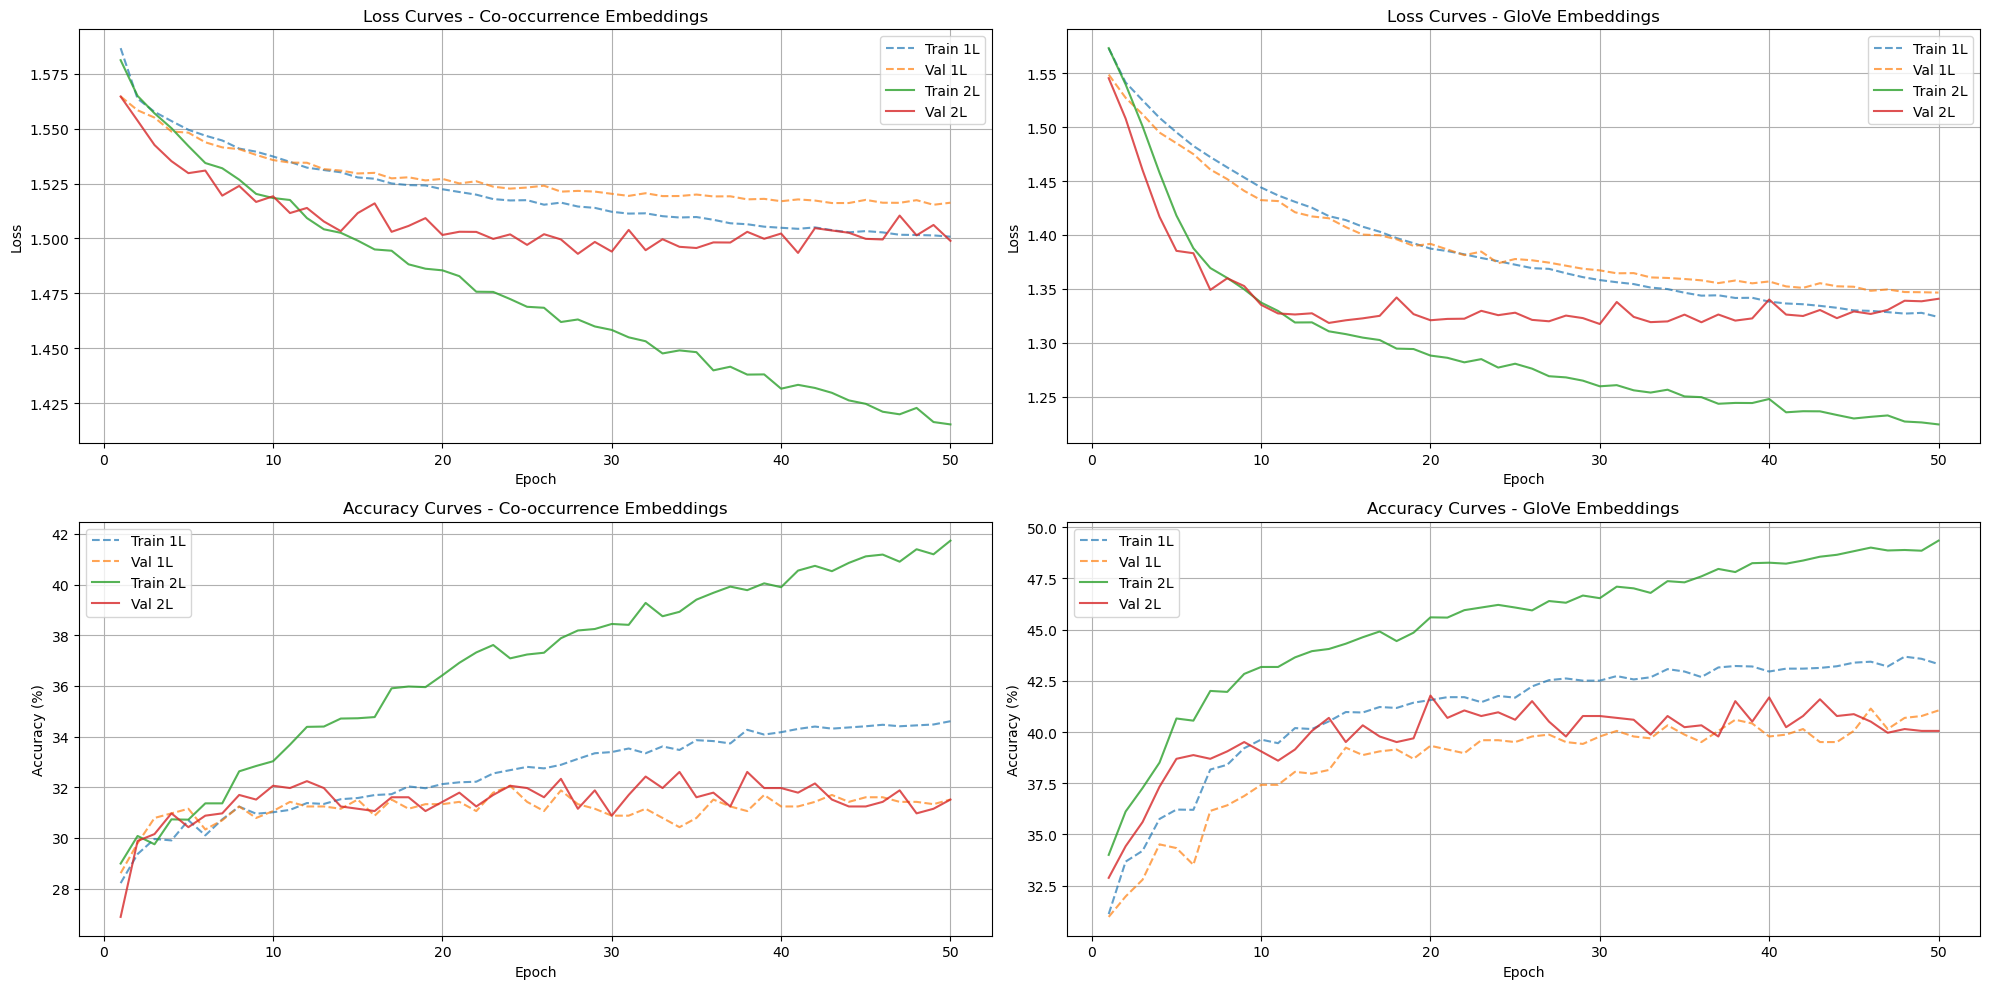

In [41]:
# Plot all results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(20, 10))

# Plot 1: Loss curves - Co-occurrence
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_c1, label='Train 1L', linestyle='--', alpha=0.7)
plt.plot(epochs, val_loss_c1, label='Val 1L', linestyle='--', alpha=0.7)
plt.plot(epochs, train_loss_c2, label='Train 2L', alpha=0.8)
plt.plot(epochs, val_loss_c2, label='Val 2L', alpha=0.8)
#plt.plot(epochs, train_loss_c3, label='Train 3L', linewidth=2)
#plt.plot(epochs, val_loss_c3, label='Val 3L', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves - Co-occurrence Embeddings')
plt.legend()
plt.grid(True)

# Plot 2: Loss curves - GloVe
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss_g1, label='Train 1L', linestyle='--', alpha=0.7)
plt.plot(epochs, val_loss_g1, label='Val 1L', linestyle='--', alpha=0.7)
plt.plot(epochs, train_loss_g2, label='Train 2L', alpha=0.8)
plt.plot(epochs, val_loss_g2, label='Val 2L', alpha=0.8)
#plt.plot(epochs, train_loss_g3, label='Train 3L', linewidth=2)
#plt.plot(epochs, val_loss_g3, label='Val 3L', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves - GloVe Embeddings')
plt.legend()
plt.grid(True)

# Plot 3: Accuracy curves - Co-occurrence
plt.subplot(2, 2, 3)
plt.plot(epochs, train_acc_c1, label='Train 1L', linestyle='--', alpha=0.7)
plt.plot(epochs, val_acc_c1, label='Val 1L', linestyle='--', alpha=0.7)
plt.plot(epochs, train_acc_c2, label='Train 2L', alpha=0.8)
plt.plot(epochs, val_acc_c2, label='Val 2L', alpha=0.8)
#plt.plot(epochs, train_acc_c3, label='Train 3L', linewidth=2)
#plt.plot(epochs, val_acc_c3, label='Val 3L', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves - Co-occurrence Embeddings')
plt.legend()
plt.grid(True)

# Plot 4: Accuracy curves - GloVe
plt.subplot(2, 2, 4)
plt.plot(epochs, train_acc_g1, label='Train 1L', linestyle='--', alpha=0.7)
plt.plot(epochs, val_acc_g1, label='Val 1L', linestyle='--', alpha=0.7)
plt.plot(epochs, train_acc_g2, label='Train 2L', alpha=0.8)
plt.plot(epochs, val_acc_g2, label='Val 2L', alpha=0.8)
#plt.plot(epochs, train_acc_g3, label='Train 3L', linewidth=2)
#plt.plot(epochs, val_acc_g3, label='Val 3L', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves - GloVe Embeddings')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
# ============================================
# Calculate Training Accuracy (No Re-training!)
# ============================================

print("="*80)
print("TRAINING vs TEST ACCURACY COMPARISON")
print("="*80)

# Co-occurrence 1-layer
train_acc_c1 = check_accuracy(train_loader, model_cooccur_1, device)
print(f"\nCo-occurrence 1-layer:")
print(f"  Training Accuracy: {train_acc_c1:.2f}%")
print(f"  Test Accuracy:     30.09%")  # Your recorded result
print(f"  Gap:               {train_acc_c1 - 30.09:.2f}%")

# Co-occurrence 2-layers
train_acc_c2 = check_accuracy(train_loader, model_cooccur_2, device)
print(f"\nCo-occurrence 2-layers:")
print(f"  Training Accuracy: {train_acc_c2:.2f}%")
print(f"  Test Accuracy:     31.00%")  # Your recorded result
print(f"  Gap:               {train_acc_c2 - 31.00:.2f}%")

# GloVe 1-layer
train_acc_g1 = check_accuracy(train_loader_glove, model_glove_1, device)
print(f"\nGloVe 1-layer:")
print(f"  Training Accuracy: {train_acc_g1:.2f}%")
print(f"  Test Accuracy:     41.86%")  # Your recorded result
print(f"  Gap:               {train_acc_g1 - 41.86:.2f}%")

# GloVe 2-layers
train_acc_g2 = check_accuracy(train_loader_glove, model_glove_2, device)
print(f"\nGloVe 2-layers:")
print(f"  Training Accuracy: {train_acc_g2:.2f}%")
print(f"  Test Accuracy:     40.86%")  # Your recorded result
print(f"  Gap:               {train_acc_g2 - 40.86:.2f}%")

print("="*80)

TRAINING vs TEST ACCURACY COMPARISON

Co-occurrence 1-layer:
  Training Accuracy: 34.61%
  Test Accuracy:     30.09%
  Gap:               4.52%

Co-occurrence 2-layers:
  Training Accuracy: 41.74%
  Test Accuracy:     31.00%
  Gap:               10.74%

GloVe 1-layer:
  Training Accuracy: 43.32%
  Test Accuracy:     41.86%
  Gap:               1.46%

GloVe 2-layers:
  Training Accuracy: 49.34%
  Test Accuracy:     40.86%
  Gap:               8.48%


In [43]:
# Final comparison table
print("\n" + "="*80)
print("FINAL RESULTS COMPARISON - ALL EXPERIMENTS")
print("="*80)
print(f"{'Model':<30} {'Test Accuracy':<15}")
print("-"*80)
print(f"{'Co-occurrence 1-layer':<30} {test_acc_c1:>12.2f}%")
print(f"{'Co-occurrence 2-layers':<30} {test_acc_c2:>12.2f}%")
#print(f"{'Co-occurrence 3-layers':<30} {test_acc_c3:>12.2f}%")
print("-"*80)
print(f"{'GloVe 1-layer':<30} {test_acc_g1:>12.2f}%")
print(f"{'GloVe 2-layers':<30} {test_acc_g2:>12.2f}%")

print("="*80)

# Analysis
print("\nOBSERVATIONS:")
print(f"- Best Co-occurrence model: {max(test_acc_c1, test_acc_c2):.2f}%")
print(f"- Best GloVe model: {max(test_acc_g1, test_acc_g2, ):.2f}%")
print(f"- Overall best model: {max(test_acc_c1, test_acc_c2, test_acc_g1, test_acc_g2):.2f}%")


FINAL RESULTS COMPARISON - ALL EXPERIMENTS
Model                          Test Accuracy  
--------------------------------------------------------------------------------
Co-occurrence 1-layer                 29.95%
Co-occurrence 2-layers                31.99%
--------------------------------------------------------------------------------
GloVe 1-layer                         40.68%
GloVe 2-layers                        41.90%

OBSERVATIONS:
- Best Co-occurrence model: 31.99%
- Best GloVe model: 41.90%
- Overall best model: 41.90%


# Observations on Network Performance with GloVe Embeddings and Co-occurrence Matrix

## 1. GloVe Embeddings:

- Using a single-layer network with GloVe embeddings yields similar results to a two-layer network with a ReLU activation function (two-layer GloVe: 41.90% vs one-layer GloVe : 40.68% test accuracy).

## 2. Co-occurrence Matrix:

- With the co-occurrence matrix, the two-layer network with a ReLU activation shows improved test accuracy compared to the single-layer network (Co-occurrence 2-layers: 31.99% vs Co-occurrence 1-layer: 29.95%).

## Conclusion:

While a single-layer network performs adequately with GloVe embeddings, the two-layer network with ReLU is more effective in capturing relationships than the co-occurrence matrix, leading to better test accuracy.

Additionally, after experimenting with different hyperparameter combinations, this two-layer network with a ReLU consistently surpassed other network configurations, demonstrating its robustness across various settings.

---

# Comparison of GloVe and Co-Occurrence Matrix Embeddings

When I compared **GloVe embeddings** with **co-occurrence matrix embeddings**, I observed a significant performance difference. Using the best-performing network configuration—a model with **two linear layers and one ReLU activation**—GloVe embeddings achieved a test accuracy of approximately **41%**, compared to **31%** with co-occurrence matrix embeddings.

This result highlights the effectiveness of GloVe embeddings in capturing meaningful relationships within the dataset, leading to improved performance in our selected network architecture.

---

# Analysis of Training vs Test Accuracy

the models showed varying levels of generalization across different configurations:

## Overfitting Analysis:

- **GloVe 1-layer**: Minimal overfitting with only approximately 1.5% gap between training (43.32%) and test accuracy (41.86%), indicating excellent generalization.

- **GloVe 2-layers**: More overfitting than 1-layer GloVe model with approximately 8.5% gap between training (49.34%) and test accuracy (41.90%).

- **Co-occurrence 2-layers**: Significant overfitting with approximately 10% gap between training (41.74%) and test accuracy (31.00%), suggesting the model memorizes training patterns that don't generalize well.

## Key Observation:

The GloVe 1-layer model demonstrates the best balance between model capacity and generalization, achieving competitive test accuracy (41.86%) while maintaining minimal overfitting. This suggests that simpler architectures with high-quality embeddings can outperform more complex models, especially on datasets of limited size.

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
3. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
4. You have two options for the submission. You need to either submit your final .ipynb notebook, or its "pdf" version. Note that in all cases, we expect you to put everything that we asked for (codes, outputs, written answers, visual results etc.) in that single file.
5. A: If you choose to submit a pdf, once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. Make sure all your solutions especially the coding parts are displayed in the pdf, it's okay if the provided codes get cut off and go into the next page because lines are not wrapped in code cells). Look at the PDF file and make sure all your solutions are there, displayed correctly. NOTE: If you have any problems with this way of extracting and downloading the PDF, you are free to use ANY tool to make it work, as long as you are able to provide a usual PDF with all the requirements formatted nicely in it.
5. B: If you choose to submit the notebook itself, download a .ipynb version of your notebook while making sure that its all-comprehensive and self-contained.
6. Please name your files as username_assignment1.ipynb or username_assignment1.pdf.
7. Submit your work to Learnhub by the deadline.

*This assignment is adapted from Stanford [CS224n](http://web.stanford.edu/class/cs224n/)*